In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import logging, tensorflow as tf


2025-06-21 18:12:29.513825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-21 18:12:29.513883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-21 18:12:29.579031: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-21 18:12:29.732342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

project_folder = "animal_clasificacion" 
if os.getcwd().endswith("/tf"):
    os.chdir(project_folder)

In [3]:

tf.get_logger().propagate = False        
for h in tf.get_logger().handlers:
    h.addFilter(lambda record: "png_io.cc" not in record.getMessage())


In [4]:
BASE_DIR = Path().cwd()

IMG_DIRECTORY = BASE_DIR / 'raw-img'


# Diccionario para guardar las direcciones de cada foto según su jerarquía
    # Key: Nombre animal
    # Value: Paths de las imágines
animales_show = {}


# Contiene  la cantidad de imágenes por animal
cantidad_fotos = {}

for folder in os.listdir(IMG_DIRECTORY):
    imagenes = list((IMG_DIRECTORY / folder).iterdir())
    len_images = len(imagenes)
    cantidad_fotos[folder]= len_images
    if imagenes:
        animales_show[folder] = imagenes

    

In [5]:
# Utilizamos los items de nuestro diccionario y asignamos columnas  para crear un df
df_totales = pd.DataFrame(list(cantidad_fotos.items()), columns=['Animal', 'Cuenta'])


In [6]:
total_imagenes = df_totales['Cuenta'].sum(axis=0)

df_totales['%_total'] = (df_totales['Cuenta']*100) / total_imagenes


In [7]:
print(f'El total de imágenes para contando todas las clases es de {total_imagenes}')

El total de imágenes para contando todas las clases es de 26179


In [8]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", 
             "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", 
             "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", 
             "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", 
             "ragno": "spider", "squirrel": "scoiattolo"}

df_totales['Animal'] = df_totales['Animal'].map(translate)


In [9]:
df_totales.sort_values(by='%_total', ascending=False)

Animal  Cuenta    %_total
5        dog    4863  18.575958
4     spider    4821  18.415524
1    chicken    3098  11.833913
6      horse    2623  10.019481
9  butterfly    2112   8.067535
0        cow    1866   7.127851
8   squirrel    1862   7.112571
7      sheep    1820   6.952137
3        cat    1668   6.371519
2   elephant    1446   5.523511

/tmp/ipykernel_12/2899944834.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_totales, x='Animal', y='Cuenta', palette='pastel')


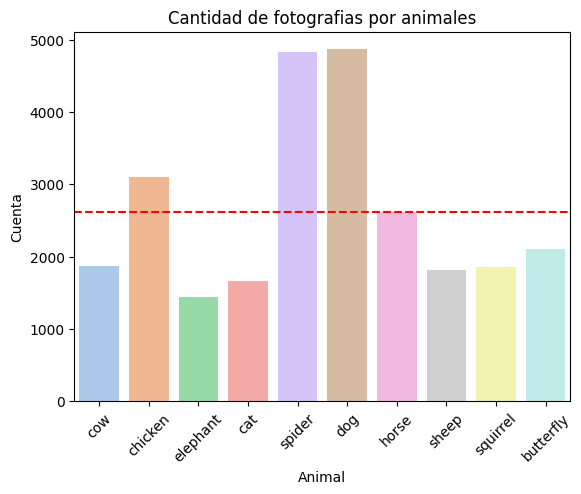

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generamos un barplot para reviar las diferencias
sns.barplot(data=df_totales, x='Animal', y='Cuenta', palette='pastel')
plt.title('Cantidad de fotografias por animales')
# Aprovechamos de poner el promedio de la cantidad de imágenes para ver que tanto se alejan de este
plt.axhline(df_totales['Cuenta'].mean(), color='r', linestyle='--')
plt.xticks(rotation=45)
plt.show()


### 🔎 **Interpretación** 

En las 10 carpetas correspondientes a los diferentes animales existe un total de **26179 imágenes**. Existe un notorio desbalanceo de clases producto a que las imágenes de arañas y perros concentran 37 % del total de lás imagenes como se puede observar más arriba. La c**lase menos representadas son los elefantes** con solo 1446 imágenes que representan un 5 % del total de las imágenes. El problema de esto es que seria ideal tener datos mejor balanceados para poder ser utilizados en los modelos. Grafique el promedio con la linea roja horizontal y se puede ver que tampoco los la mayoria de los datos se encuentran cercanos a esta linea sino más bien podriamos tirar una horizontal cerca de los 2000 y en general estarian todas las clases cercanas al poder tocar esta linea lo que nos ayudaria a poder balancear desde ya el modelo sin necesidad de aplicar otra herramienta.

### 💡 **Conclusión**:

Como medida de balanceo de datos solo **usare 2000 imágenes como tope maximo de una clase**, esto quiere decir que si en una clase existe esta cantidad entonces se seleccionara dicha cantidad y en el caso contrario se seleccionara el máximo disponible.

# **PREPARACIÓN DATA**

In [11]:
# Diccionario para guardar los nombres de los animales y los paths
new_data = {}

# Diccionario para saber la cantidad de imágenes por  clave
cantidad_fotos = {}

for folder in os.listdir(IMG_DIRECTORY):
    # Utiliza el path del directorio y la carpeta  e iterdir para seleccionar todos los archivos correspondiente a cada animal
    imagenes = list((IMG_DIRECTORY / folder).iterdir())[:2000]
    # Cantidad de imágenes
    len_images = len(imagenes)
    cantidad_fotos[folder]= len_images
    if imagenes:
        new_data[folder] = imagenes

    

In [12]:
for k, v in cantidad_fotos.items():

    print(f'La cantidad de imágenes para la clase {translate[k]} es de {v} \n')

La cantidad de imágenes para la clase cow es de 1866 

La cantidad de imágenes para la clase chicken es de 2000 

La cantidad de imágenes para la clase elephant es de 1446 

La cantidad de imágenes para la clase cat es de 1668 

La cantidad de imágenes para la clase spider es de 2000 

La cantidad de imágenes para la clase dog es de 2000 

La cantidad de imágenes para la clase horse es de 2000 

La cantidad de imágenes para la clase sheep es de 1820 

La cantidad de imágenes para la clase squirrel es de 1862 

La cantidad de imágenes para la clase butterfly es de 2000 



# **Visualizando los datos de imágenes**

In [13]:
# Sacando solo 1 imágenes por animal
first_item = { key:new_data[key][0] for i, (key, value) in enumerate(new_data.items())}

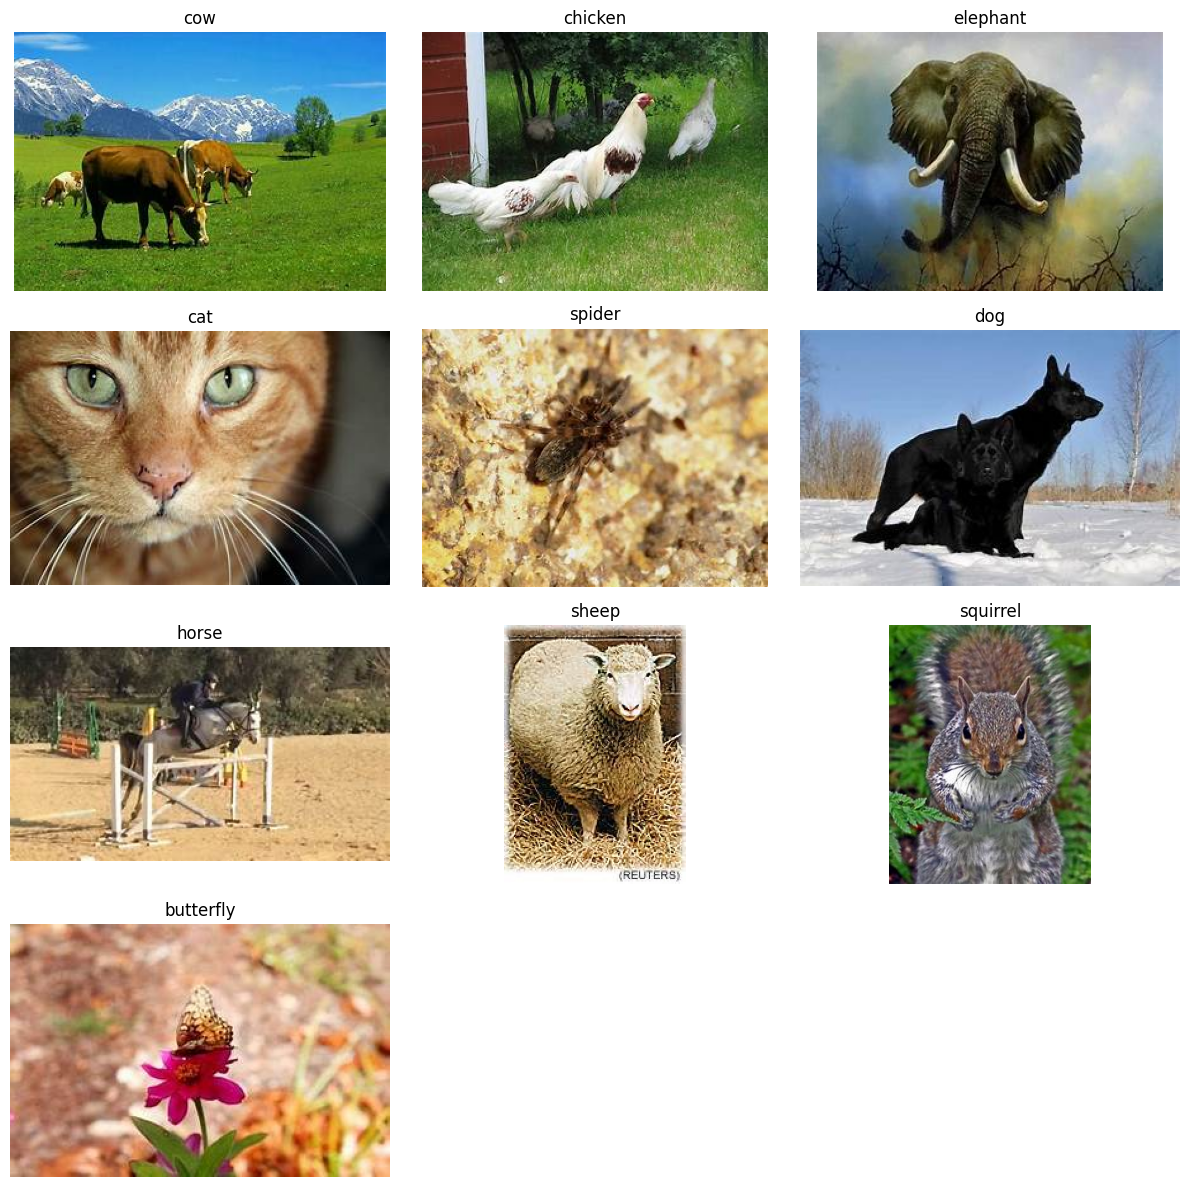

In [14]:
from PIL import Image

# Generando la figura con 12 celdas
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

# Aplanando los ejes para realizar la asignación más facil
axes = axes.flatten()

# For loop para iterar sobre la primera imagen de cada animal
for i, (clase, path) in enumerate(first_item.items()):

    # Abriendo la imágen
    img = Image.open(path)
    # Cambiando el nombre de la tag original a la traducida
    clase = translate[clase]
    axes[i].imshow(img)
    axes[i].set_title(clase, fontsize=12)
    axes[i].axis('off')

# Sacando los graficos no ocupados
for j in range(i+1,len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# **PREPARACIÓN DE LOS DATOS**

In [15]:
class_names = sorted(new_data.keys())
label_map   = {cls:i for i,cls in enumerate(class_names)}

print(f'Los nombres de las clases son {class_names}')
print()
print(label_map)

Los nombres de las clases son ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

{'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}


Lo primero es extraer los nombre de clase para poder transformarlos a numéricos y de esta forma poder pasarselo a la red neuronal

In [16]:
import random
import numpy as np, random, tensorflow as tf

seed = 123

random.seed(seed)

paths   = []
labels  = []
for cls, lst in new_data.items():
    paths.extend(map(str, lst))
    labels.extend([label_map[cls]] * len(lst))
    


El siguiente paso consiste en iterar sobre los datos que tienen como llave los nombres de los animales y los value como los paths de las imagenes para extraer estos datos y asignarle el numero de label correspondiente.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np, random
seed = 123
VAL_RATIO  = 0.15   # 15 %
TEST_RATIO = 0.15   # 15 %
# 2️⃣ Primero separas el TEST de forma estratificada
train_paths, test_paths, train_lbls, test_lbls = train_test_split(
    paths,
    labels,
    test_size = TEST_RATIO,
    stratify  = labels,
    random_state = seed
)

# 3️⃣ Ahora separas VALIDATION dentro del set de entrenamiento restante
train_paths, val_paths, train_lbls, val_lbls = train_test_split(
    train_paths,
    train_lbls,
    test_size = VAL_RATIO / (1 - TEST_RATIO),  # ← ajusta a proporción total
    stratify  = train_lbls,
    random_state = seed
)




In [17]:
import random
zipped = list(zip(paths, labels)) # Con esto cada path tiene su correspondiente label
random.shuffle(zipped) # Revolvemos los datos
paths, labels = zip(*zipped)

## ENTRENAMIENTO Y VALIDACIÓN

In [ ]:
# 4️⃣ A numpy para tf.data
train_paths = np.array(train_paths)
val_paths   = np.array(val_paths)
test_paths  = np.array(test_paths)

train_lbls  = np.array(train_lbls, dtype=np.int32)
val_lbls    = np.array(val_lbls,   dtype=np.int32)
test_lbls   = np.array(test_lbls,  dtype=np.int32)

## Normalización, redimensionado y batch

In [19]:

data_dir = Path('raw-img')
img_size = (224, 224)
batch_size = 32

def load_image(p, y):
    img = tf.io.read_file(p)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size) # resize
    img = tf.cast(img, tf.float32) / 255.0 # Normalización
    return img, y




A cada imágen se redimensionará a 224x22 para garantizar que todas las entradas tengan un tamaño consistente, evitando problemas de incompatibilidades además de optimizar el proceso de batches. 
Además se le aplicara una normalización dividiendo los pixeles por 255 para de esta forma tener valores de [0 , 1] para facilitar la convergencia del modelo además  de mejorar el rendimiento de diversos modelos.

In [20]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1,0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def aug_map(x,y): return augment(x, training=True), y

2025-06-21 18:12:34.623917: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-21 18:12:34.792544: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-21 18:12:34.792739: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### 🎓 **Fundamentación** 
Debido a la cantidad limitada de imágenes disponible que dejamos para entrenar el modelo, aplicamos data augmentation como una forma de generar variaciones artificiales de las imagene sorgiinales. Esto principalemnte para tratar de evitar el overfitting y a su vez mejorar la robustez del mismo.

Esta capa incluye las siguientes trasnformaciones:

- **RandomFlip("horizontal"):** Voltea la imagen horizontalmente (espejo).

- **RandomRotation(0.1):** Rota la imagen hasta un 10% (≈36°). Este valor es suficiente sin distorcionar la imagen

- **RandomZoom(0.2):** Aplica zoom aleatorio (hasta un 20% de acercamiento o alejamiento).

- **RandomTranslation(0.1, 0.1):** Desplaza la imagen un 10% en altura y anchura.

- **RandomContrast(0.1):** Varía el contraste en un 10%.

Estas transformaciones se aplican en tiempo real durante el entrenamiento (sin guardarse las imágenes aumentadas).

---

In [ ]:
train_ds = (tf.data.Dataset
            .from_tensor_slices((train_paths, train_lbls))
            .shuffle(len(train_paths), seed=seed)         
            .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
            .map(aug_map,   num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset
          .from_tensor_slices((val_paths, val_lbls))
          .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))

test_ds = (tf.data.Dataset
           .from_tensor_slices((test_paths, test_lbls))   # ← nuevo
           .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))


### 🎓 **Fundamentación** 

Ya tenemos nuestros datos separados en train y val pero estan en formato numpy por lo que necesitamos tensores para poder pasarlos a modelos de redes neuronales.
Para nuestro caso como tenemos.

.from_tensor_slices Toma nuestros paths y labels y los transforma a slice en donde quedan (path , label) como tensores.

.shuffle toma nuestros slices y los mezcla para tener datos no ordenados ya que sino pasaremos todos los datos ordenados y esto podría ser un patron falso que le estemos pasando al modelo. En este caso usamos todo el tamaño  del dataframe para hacer el shuffle.

Posterior los dos maps toman la funcion load_image y aug_map  para aplicar a nuestras slices tanto la carga de imágenes como el gumento de datos.

Por ultimo utilizamos batchs de 32 por lo que se pasaran de lotes de 32 imagenes de esta manera mejorando el uso de la memoría y por ultimo utilizado maxima velocidad con .prefetch gracias a que tenemos GPU podemos asegurarnos con esto que mientras los lotes esten procesando los datos siguientes ya esten listos para ser procesado.



# **MODELO**

Como he definido más arriba el modelo tendra imágenes de size 224x224 y son rgb por lo que su input_shape es de 24, 224, 3. El primer modelo consiste en 4 capas convolucionales cada uno con batchnormalization para ayudar al entrenamiento y tratar de reducir el posible overfitting que pueda existir, además de capas dropouts al final de cada features maps apagando neuronas para que al modelo le sea más dificil aprender obligandolo a tratar de buscar patrones más complejos. Por ultimo una capa flatten la cual se encuentra totalmente conectada a una capa densa de 512 neuronas que termina con la ultima capa dropout en conjunto con la ultima capa densa con la funcion de activacion softmax.

Para la compilación del modelo utilice Adam como funcion de optimizador como loss sparse_categorical_crossentropy y como metrica a mirar accuracy, ya que lo que me interesa es que se trate de equivocar lo menos posible

In [25]:
import os, warnings, logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # oculta INFO y WARNING C++
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [63]:

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers, callbacks

num_classes = len(class_names)

model = Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),  
    
    layers.Conv2D(256, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(num_classes, activation='softmax')     
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
        tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
    ],
    verbose=2

)

Epoch 1/50


2025-06-22 01:27:19.969373: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_33/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


409/409 - 53s - loss: 2.3371 - accuracy: 0.2121 - val_loss: 11.7908 - val_accuracy: 0.1268 - lr: 1.0000e-04 - 53s/epoch - 129ms/step
Epoch 2/50
409/409 - 51s - loss: 2.0558 - accuracy: 0.2673 - val_loss: 4.4998 - val_accuracy: 0.2711 - lr: 1.0000e-04 - 51s/epoch - 125ms/step
Epoch 3/50
409/409 - 51s - loss: 1.9414 - accuracy: 0.3147 - val_loss: 4.2560 - val_accuracy: 0.2607 - lr: 1.0000e-04 - 51s/epoch - 125ms/step
Epoch 4/50
409/409 - 51s - loss: 1.8543 - accuracy: 0.3522 - val_loss: 2.8008 - val_accuracy: 0.3464 - lr: 1.0000e-04 - 51s/epoch - 125ms/step
Epoch 5/50
409/409 - 51s - loss: 1.7810 - accuracy: 0.3800 - val_loss: 2.1970 - val_accuracy: 0.3632 - lr: 1.0000e-04 - 51s/epoch - 125ms/step
Epoch 6/50
409/409 - 51s - loss: 1.7000 - accuracy: 0.4068 - val_loss: 2.4827 - val_accuracy: 0.3532 - lr: 1.0000e-04 - 51s/epoch - 125ms/step
Epoch 7/50
409/409 - 51s - loss: 1.6467 - accuracy: 0.4204 - val_loss: 2.3551 - val_accuracy: 0.3564 - lr: 1.0000e-04 - 51s/epoch - 125ms/step
Epoch 8/5

In [64]:
from sklearn.metrics import accuracy_score


y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_true, y_pred)

print(f'El accuracy es de {acc}')

88/88 [==============================] - 2s 18ms/step
El accuracy es de 0.5428571428571428


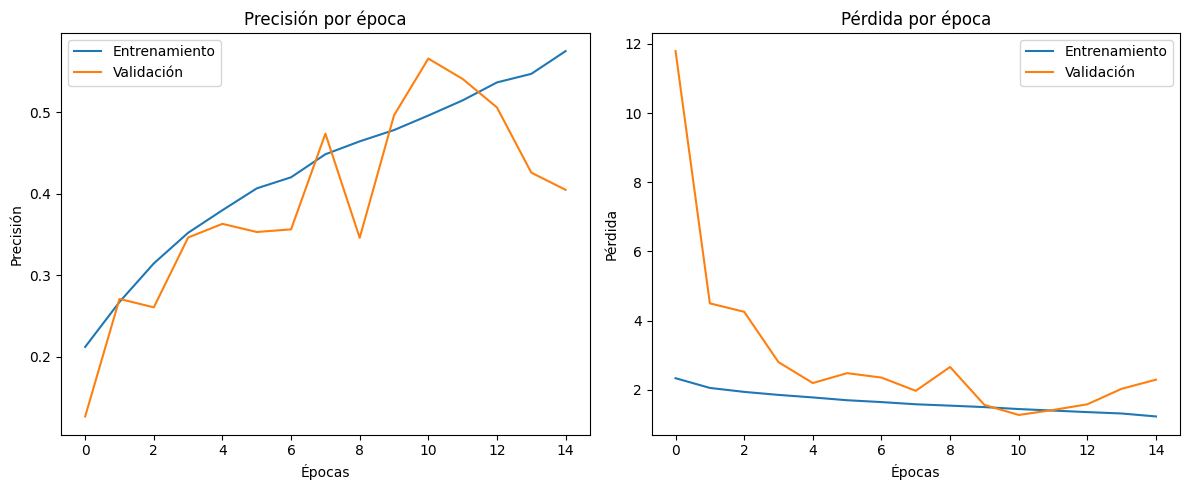

In [65]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()


plt.tight_layout()
plt.show()



88/88 [==============================] - 2s 18ms/step
Classification Report:
              precision    recall  f1-score   support

        cane       0.57      0.23      0.32       300
     cavallo       0.64      0.48      0.55       300
    elefante       0.35      0.78      0.48       217
    farfalla       0.82      0.76      0.79       300
     gallina       0.71      0.68      0.70       300
       gatto       0.51      0.42      0.46       250
       mucca       0.51      0.29      0.37       280
      pecora       0.45      0.60      0.51       273
       ragno       0.77      0.58      0.67       300
  scoiattolo       0.40      0.64      0.50       280

    accuracy                           0.54      2800
   macro avg       0.57      0.55      0.53      2800
weighted avg       0.59      0.54      0.54      2800



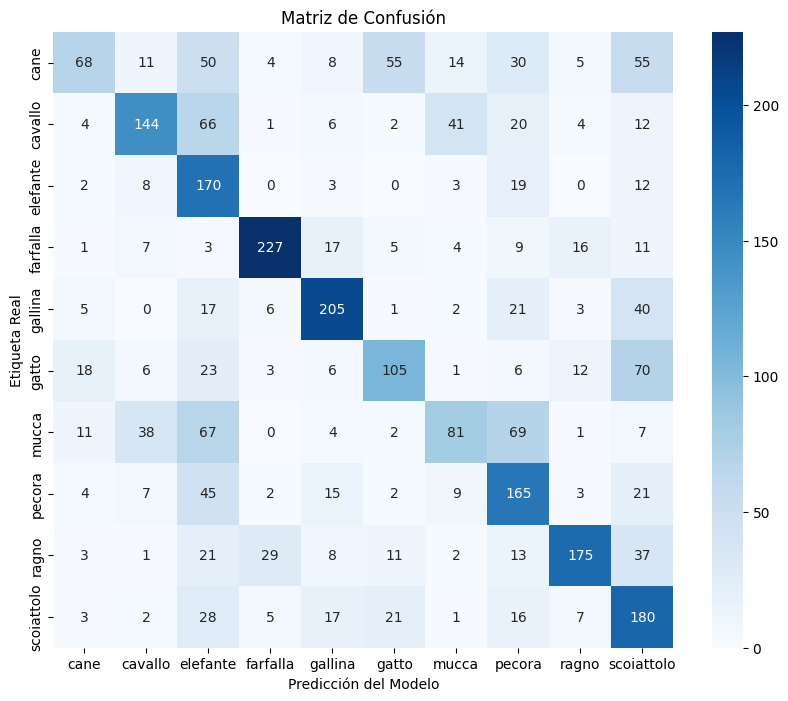

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las etiquetas verdaderas y las predicciones
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generar el Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generar la Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()



## ✏️  **INTERPRETACIÓN**

### **Precisión**

Según lo observado en los datos y gráficos se ve de forma clara que en general el modelo no logra explicar los datos ya que la linea de validación la mayor parte de las épocas se encuentra por debajo de la linea de training por lo tanto con una menor precisión y tambien con una curva llena de picos lo que habla de la imposibilidad de generalizar del modelo y su nula o poca capacidad para poder generalizar los datos. En general siempre la validación se desempeña peor que el entrenamiento a excepción de las epocas 7 y 10 donde la validación se desempeña mejor que el entrenamiento pero después de esto vuelve a disminuir.

### **Loss**

Por otro lado la pérdida del modelo desciende desde la primera epoca hasta el final pero  este cambio tiene una pendiente casi 0 hablando de la poca capacidad del modelo para poder encontar los mínimos. Se evidencia de manera clara igualmente que la perdida es bastante volátil ya que en diferentes epocas sube y baja, en vez de bajar de manera constante lo que nos entrega pistas de la imposibilidad del modelo para generalizar de manera correcta.


### **Generalización**

Esta mala generalización apreciada en los puntos anteriores se ven fuertemente reforzada por las métricas observadas en la matriz de confusión en donde hay una clara diferencia en el rendimiento de las diferentes clases como en farfalla(mariposa) que alcanza un f1score de 0.79 y clases como cane (perro) y mucca (vaca) solo tienen un 0.32 y 37 respectivamente, indicando fuertemente que el modelo no logra diferenciar de manera correcta las diferentes clases

## **CONCLUSIÓN**


El modelo actual no puede generalizar ni captar bien la señal de los datos que tenemos en el modelo según lo observado tanto en la presición como en la pérdida. 

Los picos observados hablan de que el modelo es bastante sensible a los batches específicos de datos, lo que refuerza la idea que el modelo se encuentra memorizando ruido en lugar de aprender de manera robusta y general.

Los patrones observados hablan de un claro overfitting de los datos ya que el entrenamiento siempre se encuentra desempeñado mejor que los datos de validación aún cuando los datos de entrenamiento incluso tienen datos augmentados.

En el siguiente modelo pretendo probar una red neuronal más profunda para ver si es posible lograr un mayor entendimiento del modelo en los datos. Utilizar batchnormalization, kernel regularization y además global average pooling parecen ser buenas medidas para evitar el overfiting claro observado en nuestro modelo actual.



In [ ]:
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.models import Sequential


# ---------- MODELO ------------------------------------------------------
num_classes = len(class_names)


model_v2 = Sequential([
    # Bloque 1
    layers.Conv2D(32, (5, 5), activation='relu', padding='same',
                  input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Bloque 2
    layers.Conv2D(64, (5, 5), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Bloque 3
    layers.Conv2D(128, (5, 5), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Bloque 4
    layers.Conv2D(256, (5, 5), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Bloque 5
    layers.Conv2D(512, (5, 5), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Bloque 6
    layers.Conv2D(1024, (5, 5), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(num_classes, activation='softmax')
])

model_v2.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_v2 = model_v2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
        tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
    ]
    ,
    verbose=2
)

Epoch 1/50
409/409 - 64s - loss: 3.3804 - accuracy: 0.3201 - val_loss: 3.3609 - val_accuracy: 0.2604 - lr: 1.0000e-04 - 64s/epoch - 155ms/step
Epoch 2/50
409/409 - 59s - loss: 2.8243 - accuracy: 0.4654 - val_loss: 2.6633 - val_accuracy: 0.5096 - lr: 1.0000e-04 - 59s/epoch - 144ms/step
Epoch 3/50
409/409 - 59s - loss: 2.5666 - accuracy: 0.5404 - val_loss: 2.3959 - val_accuracy: 0.5864 - lr: 1.0000e-04 - 59s/epoch - 144ms/step
Epoch 4/50
409/409 - 59s - loss: 2.3752 - accuracy: 0.5808 - val_loss: 2.5795 - val_accuracy: 0.5118 - lr: 1.0000e-04 - 59s/epoch - 143ms/step
Epoch 5/50
409/409 - 59s - loss: 2.2065 - accuracy: 0.6241 - val_loss: 2.4602 - val_accuracy: 0.5404 - lr: 1.0000e-04 - 59s/epoch - 143ms/step
Epoch 6/50
409/409 - 59s - loss: 2.0334 - accuracy: 0.6635 - val_loss: 2.2221 - val_accuracy: 0.5904 - lr: 1.0000e-04 - 59s/epoch - 144ms/step
Epoch 7/50
409/409 - 59s - loss: 1.9304 - accuracy: 0.6802 - val_loss: 2.2067 - val_accuracy: 0.6246 - lr: 1.0000e-04 - 59s/epoch - 144ms/step

### ❗ **Justificación**
Para el siguiente modelo genere un modelo de 6 bloques como el 6to como cabecera. En este a diferencia del anterior agregamos mayor cantidad de neuronas llegando a una capa densa de 1024 neuronas lo que permitirá al modelo poder aprender relaciones más complejas. 

En cada de una de los bloques se inclye batchnormalization sacando los Dropouts existentes esto para poder acelerar el entrenamiento y disminuir el overfitting asi como la inclusión de los kernel_regularizator lo cuales tienen como fin penalizar los coeficientes del modelo para lograr que este pueda generalizar de mejor manera. 

Por ultimo en la cabecera se agrego un 10 % más en el apagado de las neuronas de la capa final tambien como medida contra el overfitting y un cambio importante es la adición de global average pooling el cual a diferencia del flaten utiliza el promedio de los vectores en vez de utilizar cada vector individual lo que significa una disminución de parámetros importante. 

In [46]:
from sklearn.metrics import accuracy_score


y_true_v2 = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs_v2 = model_v2.predict(val_ds)
y_pred_v2 = np.argmax(y_pred_probs_v2, axis=1)

acc = accuracy_score(y_true_v2, y_pred_v2)

print(f'El accuracy es de {acc}')

88/88 [==============================] - 3s 31ms/step
El accuracy es de 0.8564285714285714


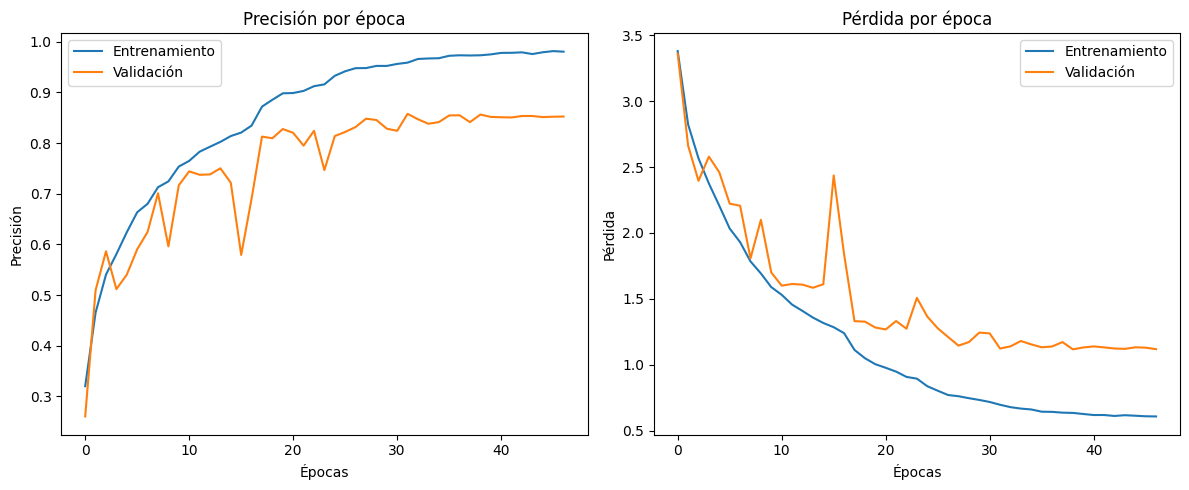

In [47]:
import matplotlib.pyplot as plt

acc = history_v2.history['accuracy']
val_acc = history_v2.history['val_accuracy']

loss = history_v2.history['loss']
val_loss = history_v2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()


plt.tight_layout()
plt.show()



Classification Report:
              precision    recall  f1-score   support

        cane       0.83      0.74      0.78       300
     cavallo       0.86      0.82      0.84       300
    elefante       0.76      0.93      0.83       217
    farfalla       0.81      0.94      0.87       300
     gallina       0.92      0.91      0.91       300
       gatto       0.89      0.87      0.88       251
       mucca       0.86      0.84      0.85       280
      pecora       0.85      0.83      0.84       273
       ragno       0.89      0.87      0.88       300
  scoiattolo       0.90      0.84      0.87       279

    accuracy                           0.86      2800
   macro avg       0.86      0.86      0.86      2800
weighted avg       0.86      0.86      0.86      2800



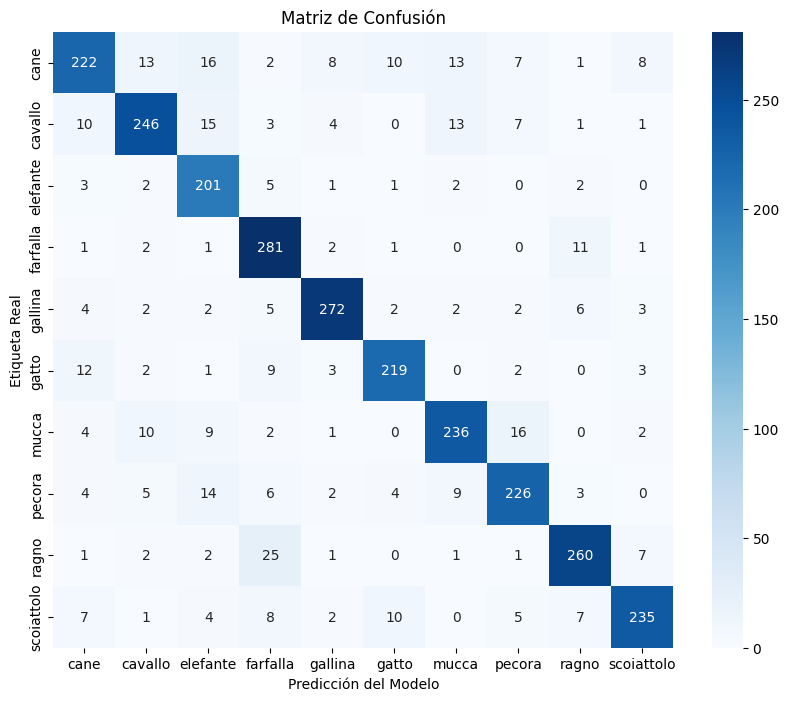

In [48]:


# Generar el Classification Report
print("Classification Report:")
print(classification_report(y_true_v2, y_pred_v2, target_names=class_names))

# Generar la Matriz de Confusión
cm = confusion_matrix(y_true_v2, y_pred_v2)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()



## ✏️  **INTERPRETACIÓN**

### **Precisión** 
En epocas tempranas y por poco tiempo la validación se desempeña mejor que el entrenamiento, lo que se ve rápidamente cambiado a medida que sigue el entrenamiento donde en especial en los datos de validación se puede ber bastante ruido hasta aproximado la éopoca 35 donde el entrenamiento parece estabilizarse. La precisión para el segundo modelo en los datos de testeo es de 0.85 bastante más alto que los 0.54 del primer modelo.

### **Loss**

La pérdida tiene en general una perdida constante pero localmente se pueden observar varios picos lo que habla de la inestabilidad que aún posee el modelo. Similar patron que el evidenciado en la precisión en la epoca 35 aprox. la pérdida viene disminuyendo lo que habla que la regularización del kernel está funcionando pero en este punto cercano a los 35 ya se mantiene casi constante producto del early stoping.

### **Generalización**

En este caso todas las métricas del primer modelo subieron bastante casi todos de manera conjunta a excepción de cane que si bien aumento del primero no lo hizo de una manera an consistente como los otros. A diferencia entre el modelo anterior el GAP entre validación y entrenamiento es menor lo que habala de una mejor generalización pero no del todo.

## **CONCLUSIÓN**

Según lo observado en los datos está claro que las medidas como batchnorm, dropout, kernel regularization entre otros fueron de gran ayuda para el modelo viendo aumentadas en general en todas sus métricas. Aún así el modelo sufre de overfitting como se encuentra respaldado en las graficas observadas arriba.

El 85 % de accuracy si bien es un muy buen punto para un modelo los problemas de overfiting es claro y persistente. Explorar otras formas de poder entrenar el modelo como transfer learning parecen buenas ideas.

El proximo paso será tratar de aumentar en mayor medida todas las métricas aprovechandonos de un modelo ya entrenado como MobilNetV2 para de esta forma alcanczar más de un 90% de esta score


In [49]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam


base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  
    weights='imagenet' 
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_v3 = tf.keras.Model(inputs, outputs)

## 5. Compilación con learning rate bajo
model_v3.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 6. Entrenamiento con callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model_v3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  
    callbacks=callbacks,
    verbose=1
)





Epoch 1/50
409/409 [==============================] - 28s 64ms/step - loss: 1.9685 - accuracy: 0.3584 - val_loss: 0.8102 - val_accuracy: 0.8282


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
409/409 [==============================] - 24s 59ms/step - loss: 1.0349 - accuracy: 0.6680 - val_loss: 0.4741 - val_accuracy: 0.8943
Epoch 3/50
409/409 [==============================] - 24s 59ms/step - loss: 0.7940 - accuracy: 0.7515 - val_loss: 0.3658 - val_accuracy: 0.9111
Epoch 4/50
409/409 [==============================] - 24s 59ms/step - loss: 0.6632 - accuracy: 0.7911 - val_loss: 0.3049 - val_accuracy: 0.9211
Epoch 5/50
409/409 [==============================] - 24s 59ms/step - loss: 0.5894 - accuracy: 0.8130 - val_loss: 0.2746 - val_accuracy: 0.9289
Epoch 6/50
409/409 [==============================] - 24s 59ms/step - loss: 0.5488 - accuracy: 0.8234 - val_loss: 0.2539 - val_accuracy: 0.9332
Epoch 7/50
409/409 [==============================] - 24s 58ms/step - loss: 0.5349 - accuracy: 0.8311 - val_loss: 0.2393 - val_accuracy: 0.9336
Epoch 8/50
409/409 [==============================] - 24s 58ms/step - loss: 0.4907 - accuracy: 0.8439 - val_loss: 0.2259 - val_accuracy:

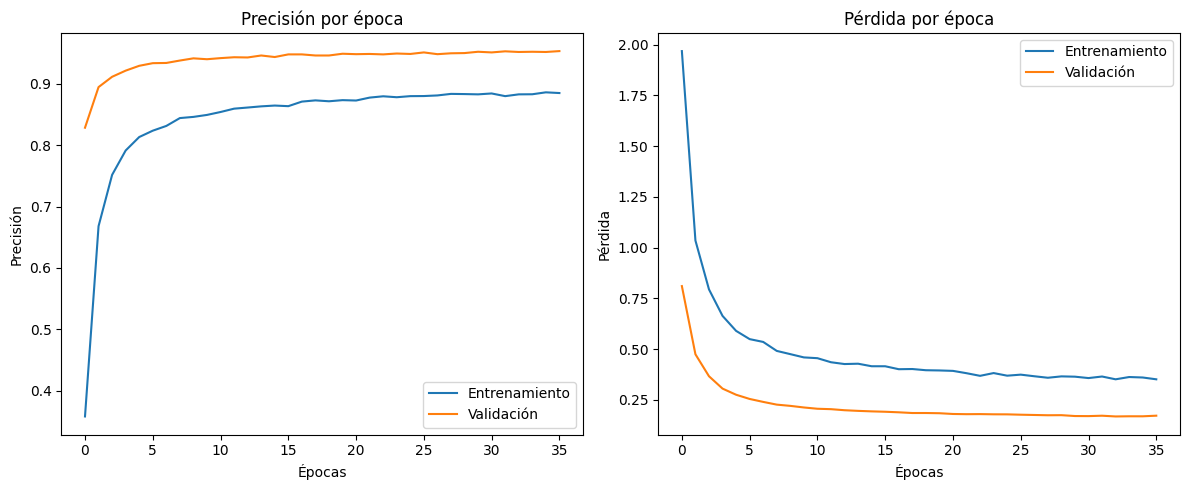

In [50]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()


plt.tight_layout()
plt.show()



In [51]:


# 1. Descongelamos el modelo base
base_model.trainable = True

print("Número de capas en el modelo base: ", len(base_model.layers))

fine_tune_at = 100 # Puedes experimentar con este número

# Congelamos todas las capas antes de la capa 'fine_tune_at'
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 2. Re-compilamos el modelo con una tasa de aprendizaje MUY baja
model_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 10 veces más bajo que antes
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Continuamos el entrenamiento
# Entrenamos por unas pocas épocas más para ajustar los pesos descongelados.
fine_tune_epochs = 10
total_epochs = len(history.epoch) + fine_tune_epochs

history_fine_tune = model_v3.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Importante para que las gráficas continúen
    validation_data=val_ds,
    callbacks=callbacks # Puedes reusar los mismos callbacks
)

Número de capas en el modelo base:  154
Epoch 36/46


409/409 [==============================] - 31s 62ms/step - loss: 0.3230 - accuracy: 0.8940 - val_loss: 0.1470 - val_accuracy: 0.9536
Epoch 37/46
409/409 [==============================] - 25s 60ms/step - loss: 0.2749 - accuracy: 0.9099 - val_loss: 0.1409 - val_accuracy: 0.9557
Epoch 38/46
409/409 [==============================] - 25s 60ms/step - loss: 0.2602 - accuracy: 0.9161 - val_loss: 0.1377 - val_accuracy: 0.9571
Epoch 39/46
409/409 [==============================] - 25s 60ms/step - loss: 0.2418 - accuracy: 0.9205 - val_loss: 0.1293 - val_accuracy: 0.9593
Epoch 40/46
409/409 [==============================] - 25s 61ms/step - loss: 0.2176 - accuracy: 0.9283 - val_loss: 0.1244 - val_accuracy: 0.9611
Epoch 41/46
409/409 [==============================] - 25s 60ms/step - loss: 0.1986 - accuracy: 0.9381 - val_loss: 0.1308 - val_accuracy: 0.9571
Epoch 42/46
409/409 [==============================] - 25s 61ms/step - loss: 0.1934 - accuracy: 0.9372 - val_loss: 0.1164 - val_accuracy: 0.96

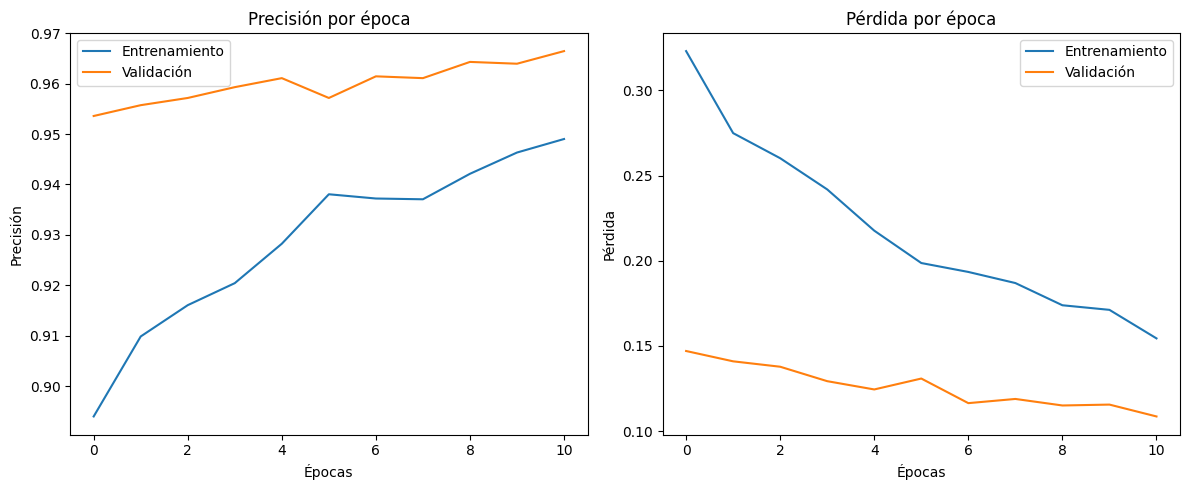

In [52]:
import matplotlib.pyplot as plt

acc = history_fine_tune.history['accuracy']
val_acc = history_fine_tune.history['val_accuracy']

loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()


plt.tight_layout()
plt.show()



In [53]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5')


In [54]:
best_model.save('mejor_modelo.h5')

In [55]:
# Suponiendo que tienes un test_ds
loss, accuracy = best_model.evaluate(val_ds)
print(f"Precisión final en el conjunto de prueba: {accuracy*100:.2f}%")

# Genera el reporte de clasificación
# (El código para esto puede variar un poco, pero la idea es usar best_model.predict)

88/88 [==============================] - 3s 33ms/step - loss: 0.1086 - accuracy: 0.9664
Precisión final en el conjunto de prueba: 96.64%



Realizando predicciones en el conjunto de validación...
1/1 [==============================] - 1s 1s/step


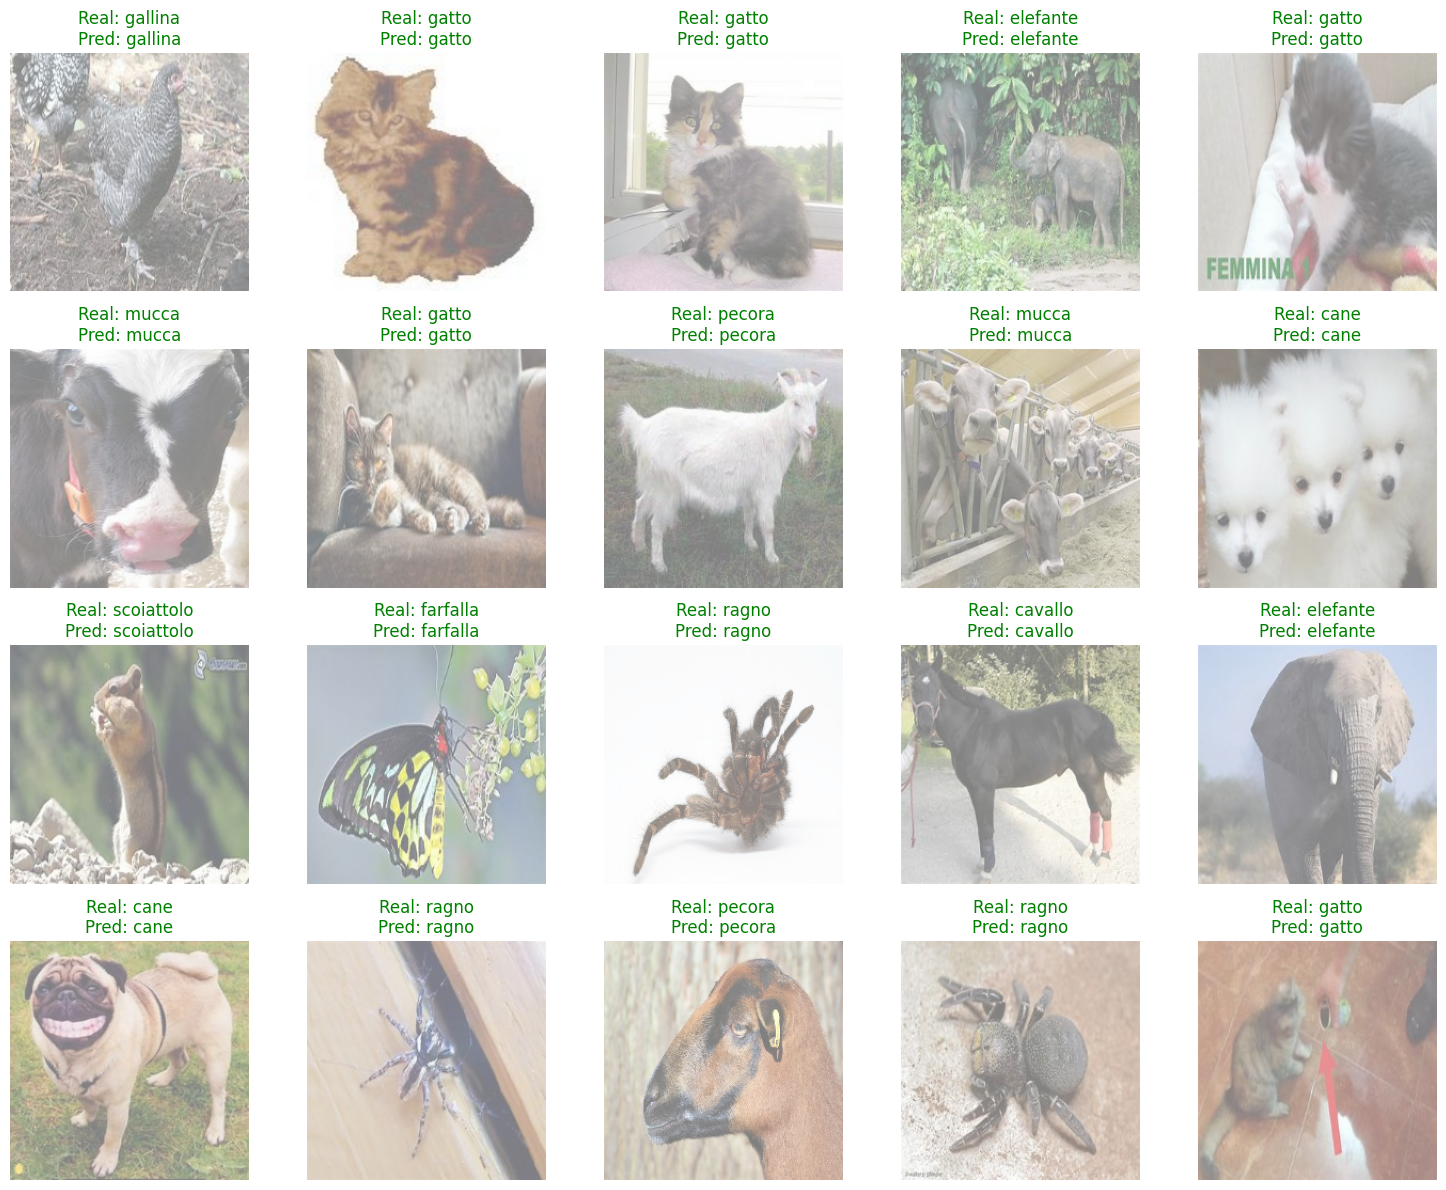

Visualización completa.


In [56]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf



print("\nRealizando predicciones en el conjunto de validación...")

for images, labels in val_ds.take(1):
    # Selecciona las primeras 20 del batch
    images_subset = images[1:21]
    labels_subset = labels[1:21]
    break 

# Hacer predicciones con el modelo
predictions = best_model.predict(images_subset)

# Obtener los índices de clase predichos (el que tiene mayor probabilidad)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener los nombres de clase reales y predichos
actual_class_names = [class_names[label.numpy()] for label in labels_subset]
predicted_class_names = [class_names[predicted_classes] for predicted_classes in predicted_classes]

# Invertir la normalización para mostrar las imágenes correctamente
# (De [-1, 1] de vuelta a [0, 255] y tipo uint8)
display_images = ((images_subset.numpy() + 1) * 127.5).astype(np.uint8)

# Mostrar las imágenes con sus etiquetas reales y predichas
plt.figure(figsize=(15, 12)) # Ajusta el tamaño de la figura si es necesario

for i in range(20):
    plt.subplot(4, 5, i + 1) # Layout de 4 filas y 5 columnas
    plt.imshow(display_images[i])

    # Define el color del título (verde si acierta, rojo si falla)
    color = 'green' if actual_class_names[i] == predicted_class_names[i] else 'red'

    # Pon el título con las etiquetas real y predicha
    plt.title(f"Real: {actual_class_names[i]}\nPred: {predicted_class_names[i]}", color=color)
    plt.axis('off') # Oculta los ejes

plt.tight_layout() # Ajusta el layout para que no se superpongan los títulos
plt.show()

print("Visualización completa.")

In [60]:
predictions = best_model.predict(test_ds)

# Obtener los índices de clase predichos (el que tiene mayor probabilidad)
predicted_classes = np.argmax(predictions, axis=1)
y_true_v3 = np.concatenate([y for x, y in test_ds], axis=0)

accuracy_score(predicted_classes, y_true_v3)

 1/88 [..............................] - ETA: 4s

88/88 [==============================] - 3s 29ms/step


0.9625